In [1]:
import os
import numpy as np
import torch
import json
import matplotlib.pyplot as plt
import cv2
import skimage
from baseline import Baseline
from deciwatch import DeciWatch
from unipose import Unipose
from unipose2 import Unipose2
from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [28]:
def get_torso_diameter(keypoints):
    if np.all(keypoints[3] == [0, 0]) or np.all(keypoints[15] == [0, 0]) or np.all(keypoints[4] == [0, 0]) or np.all(keypoints[16] == [0, 0]):
        return None

    left_torso_diameter = np.linalg.norm(keypoints[3] - keypoints[15])
    right_torso_diameter = np.linalg.norm(keypoints[4] - keypoints[16])
    torso_diameter = np.mean([left_torso_diameter, right_torso_diameter])
    
    return torso_diameter

def compute_PCK(all_gt_keypoints, all_pred_keypoints, norm):
    
    assert len(all_gt_keypoints.shape) in [3, 5]
    assert len(all_pred_keypoints.shape) in [3, 5]
        
    bools = []
        
    for batch in range(all_pred_keypoints.shape[0]):
        for frame in range(all_pred_keypoints.shape[1]):
            gt_keypoints = all_gt_keypoints[batch, frame]
            pred_keypoints = all_pred_keypoints[batch, frame]
    
            # Reshaping to 2d-coodinates
            gt_keypoints = gt_keypoints.reshape((-1, 2))
            pred_keypoints = pred_keypoints.reshape((-1, 2))
            
            # Getting the torso diameter
            torso_diameter = get_torso_diameter(gt_keypoints)
            if torso_diameter is None:
                continue
            
            if len(gt_keypoints) == 0:
                continue
            
            # Computing the distance between the groundtruthh keypoints
            # and the predicted keypoints
            dist = np.linalg.norm(gt_keypoints - pred_keypoints, axis=1)
            
            # Checking whether the distances are shorter than the torso diameter
            dist = dist <= torso_diameter * norm
            
            # Storing results of this batch-frame
            bools.append(dist.flatten())
        
    # Returning the ratio of correctly predicted keypoints
    bools = np.concatenate(bools)
    return -1 if len(bools) == 0 else np.mean(bools)


In [2]:
def heatmaps2coordinates(featuremaps):
    featuremaps = featuremaps.squeeze()
    
    num_heatmaps = 25
    
    # Dimensions of each keypoints
    num_dimensions = 2
    
    # Preallocating memory
    keypoints = np.zeros(num_dimensions * num_heatmaps)
    
    for heatmap_idx in range(num_heatmaps):
        
        # Finds the coordinates of the keypoint-heatmap
        heatmap = featuremaps[heatmap_idx]
        coordinate = np.unravel_index(heatmap.argmax(), heatmap.shape)
        
        # Stores the keypoint-coordinate
        keypoints[num_dimensions * heatmap_idx] = coordinate[0]
        keypoints[num_dimensions * heatmap_idx + 1] = coordinate[1]
    
    keypoints = keypoints.reshape((-1, 2))
    
    return keypoints

In [3]:
def heatmaps2coordinates_2(featuremaps):
    assert len(featuremaps.shape) == 5, f"Your video sequence should have the following shape: (num_batches, num_frames, num_heatmaps, height, width). Yours have shape {featuremaps.shape}"
    
    # Extracting useful info
    num_batches, num_frames, num_heatmaps = featuremaps.shape[:3]
    
    # Casting featuremaps to numpy
    featuremaps = featuremaps.detach().cpu().numpy()
    
    # Dimensions of each keypoints
    num_dimensions = 2
    
    # Preallocating memory
    keypoints = torch.zeros((num_batches, num_frames, num_dimensions * num_heatmaps))
    
    for batch_idx in range(num_batches):
        for frame_idx in range(num_frames):
            for heatmap_idx in range(num_heatmaps):
                
                # Finds the coordinates of the keypoint-heatmap
                heatmap = featuremaps[batch_idx, frame_idx, heatmap_idx]
                coordinate = np.unravel_index(heatmap.argmax(), heatmap.shape)
                
                # Stores the keypoint-coordinate
                keypoints[batch_idx, frame_idx, num_dimensions * heatmap_idx] = coordinate[0]
                keypoints[batch_idx, frame_idx, num_dimensions * heatmap_idx + 1] = coordinate[1]

    return keypoints

In [4]:
def get_video_frame(frame_idx, video_path, video_bboxes):
    cap = cv2.VideoCapture(video_path)
    i = 0

    while(cap.isOpened()):
        ret, frame = cap.read()
        if ret == True:
            if i == frame_idx:
                break

            i += 1
        else:
            raise("ERROR")
        
    frame = frame[..., ::-1]
    frame_bbox = np.round(video_bboxes[frame_idx].squeeze()).astype(int)
    frame = frame[frame_bbox[1]:frame_bbox[3], frame_bbox[0]:frame_bbox[2]]
    
    return frame


In [5]:
def draw_keypoints(frame, keypoints, width_scale, height_scale, c="blue", radius=5):
    cs = {"red": [255, 0, 0], "green": [0, 255,0], "blue": [0, 0, 255]}
    frame_new = np.copy(frame)
    keypoints[:, 0] *= height_scale
    keypoints[:, 1] *= width_scale
    keypoints = np.round(keypoints).astype(int)
    
    for keypoint in keypoints:
        rr, cc = skimage.draw.disk(keypoint, radius)
        frame_new[rr, cc] = cs[c]
        
    return frame_new

In [6]:
def get_best_model_path(model_type, finetuned_models_paths):
    finetuned_models_paths = list(filter(lambda model: model.split("/")[-2].split("_")[0] == model_type, finetuned_models_paths))
    
    best_acc = 0
    
    for path in finetuned_models_paths:
        model_best_acc = np.max(np.load(path + "val_accs.npy"))
        model_best_acc_argmax = np.argmax(np.load(path + "val_accs.npy"))
        
        if model_best_acc_argmax == 0:
            path = path.replace("finetuned_models", "pretrained_models")
            model_best_acc = np.max(np.load(path + "val_accs.npy"))
            model_best_acc_argmax = np.argmax(np.load(path + "val_accs.npy"))
        
        if model_best_acc > best_acc:
            best_acc = model_best_acc
            best_model_name = path
            best_model_epoch = path + str(model_best_acc_argmax) + "/model.pth" 
            
    return best_model_name, best_model_epoch

In [7]:
def get_model_config(model_path, model_type):
    with open(model_path.replace("finetuned_models", "pretrained_models") + "config.json", "r") as f:
        config = json.load(f)
      
    if model_type != "baseline":
        config["model_params"]["device"] = device
        
    if model_type in ["unipose", "unipose2"]:
        config["model_params"]["upper_range"] = 255
        
    return config["model_params"]

In [69]:
def load_best_models(finetuned_models_paths):
    best_baseline_name, best_baseline_epoch = get_best_model_path("baseline", finetuned_models_paths)
    print(best_baseline_name, best_baseline_epoch)
    best_baseline_config = get_model_config(best_baseline_name, "baseline")
    baseline = Baseline(**best_baseline_config)
    baseline.load_state_dict(torch.load(best_baseline_epoch, map_location=torch.device("cpu")))
    baseline = baseline.to(device)    
    
    best_deciwatch_name, best_deciwatch_epoch = get_best_model_path("deciwatch", finetuned_models_paths)
    print(best_deciwatch_name, best_deciwatch_epoch)
    best_deciwatch_config = get_model_config(best_deciwatch_name, "deciwatch")
    deciwatch = DeciWatch(**best_deciwatch_config)
    deciwatch.load_state_dict(torch.load(best_deciwatch_epoch, map_location=torch.device("cpu")))
    deciwatch = deciwatch.to(device)  
    
    best_unipose_name, best_unipose_epoch = get_best_model_path("unipose", finetuned_models_paths)
    print(best_unipose_name, best_unipose_epoch)
    best_unipose_config = get_model_config(best_unipose_name, "unipose")
    unipose = Unipose(**best_unipose_config)
    unipose.load_state_dict(torch.load(best_unipose_epoch, map_location=torch.device("cpu")))
    unipose = unipose.to(device)  
    
    best_unipose2_name, best_unipose2_epoch = get_best_model_path("unipose2", finetuned_models_paths)
    print(best_unipose2_name, best_unipose2_epoch)
    best_unipose2_config = get_model_config(best_unipose2_name, "unipose2")
    unipose2 = Unipose2(**best_unipose2_config)
    unipose2.load_state_dict(torch.load(best_unipose2_epoch, map_location=torch.device("cpu")))
    unipose2 = unipose2.to(device)
    
    return baseline, deciwatch, unipose, unipose2

In [70]:
def load_mask_rcnn_preds(frame_idx, video_annotation):
    video_heatmaps = video_annotation["heatmaps"]
    frame_heatmaps = video_heatmaps[frame_idx]
    frame_keypoints = heatmaps2coordinates(frame_heatmaps)
    
    return frame_keypoints

In [71]:
def load_gt_keypoints(data_target_dir_path, video_name, frame_idx):
    gt_heatmaps = torch.load(data_target_dir_path + video_name.replace(".mp4", "") + "/" + str(frame_idx) + ".pt")
    gt_keypoints = heatmaps2coordinates(gt_heatmaps)
    
    return gt_keypoints

In [72]:
def load_pred_keypoints(data_input_dir_path, video_name, model, is_deciwatch=False):
    
    input_heatmaps = torch.zeros((5, 25, 56, 56), dtype=float)
    
    for frame_idx in range(5):
        frame_heatmaps = torch.load(data_input_dir_path + video_name.replace(".mp4", "") + "/" + str(frame_idx) + ".pt") * 255
        input_heatmaps[frame_idx] = frame_heatmaps
        
    if is_deciwatch:
        input_heatmaps = heatmaps2coordinates_2(input_heatmaps.unsqueeze(0)).squeeze()
     
    input_heatmaps = input_heatmaps.to(device)
    pred_heatmaps = model(input_heatmaps.unsqueeze(0).float())
    pred_heatmaps = pred_heatmaps.detach().cpu().numpy().squeeze()
    
    if is_deciwatch:
        keypoints = pred_heatmaps.reshape((5, 25, 2))
    else:
        keypoints = np.zeros((5, 25, 2))
        for i in range(5):
            keypoints[i] = heatmaps2coordinates(pred_heatmaps[i])
    
    return keypoints

In [130]:
data_input_dir_path = "../../data/processed/ClimbAlong/testing/input/"
data_target_dir_path = "../../data/processed/ClimbAlong/testing/target/"
data_video_dir_path = "../../data/raw/ClimbAlong/video/"
data_annotations_dir_path = "../../data/raw/ClimbAlong/input/"

finetuned_models_paths = [f"../../finetuned_models/1/{model_name}/" for model_name in os.listdir("../../finetuned_models/1/")] + [f"../../finetuned_models/2/{model_name}/" for model_name in os.listdir("../../finetuned_models/2/")]

baseline, deciwatch, unipose, unipose2 = load_best_models(finetuned_models_paths)


../../finetuned_models/1/baseline_1684430534.955375/ ../../finetuned_models/1/baseline_1684430534.955375/20/model.pth
0.7992322884385454
../../pretrained_models/1/deciwatch_1684938562.615292/ ../../pretrained_models/1/deciwatch_1684938562.615292/2/model.pth
../../finetuned_models/1/unipose_1684317796.0789783/ ../../finetuned_models/1/unipose_1684317796.0789783/1/model.pth
../../finetuned_models/2/unipose2_1684360691.30469/ ../../finetuned_models/2/unipose2_1684360691.30469/7/model.pth


frame 0 - Mask RCNN 0.32
frame 0 - 3DConv 0.36
frame 0 - DeciWatch 0.32
frame 0 - Unipose 0.36
frame 0 - Unipose2 0.36

frame 1 - Mask RCNN 0.36
frame 1 - 3DConv 0.4
frame 1 - DeciWatch 0.12
frame 1 - Unipose 0.44
frame 1 - Unipose2 0.48

frame 2 - Mask RCNN 0.32
frame 2 - 3DConv 0.4
frame 2 - DeciWatch 0.16
frame 2 - Unipose 0.44
frame 2 - Unipose2 0.4

frame 3 - Mask RCNN 0.4
frame 3 - 3DConv 0.36
frame 3 - DeciWatch 0.28
frame 3 - Unipose 0.36
frame 3 - Unipose2 0.44

frame 4 - Mask RCNN 0.4
frame 4 - 3DConv 0.52
frame 4 - DeciWatch 0.4
frame 4 - Unipose 0.44
frame 4 - Unipose2 0.4



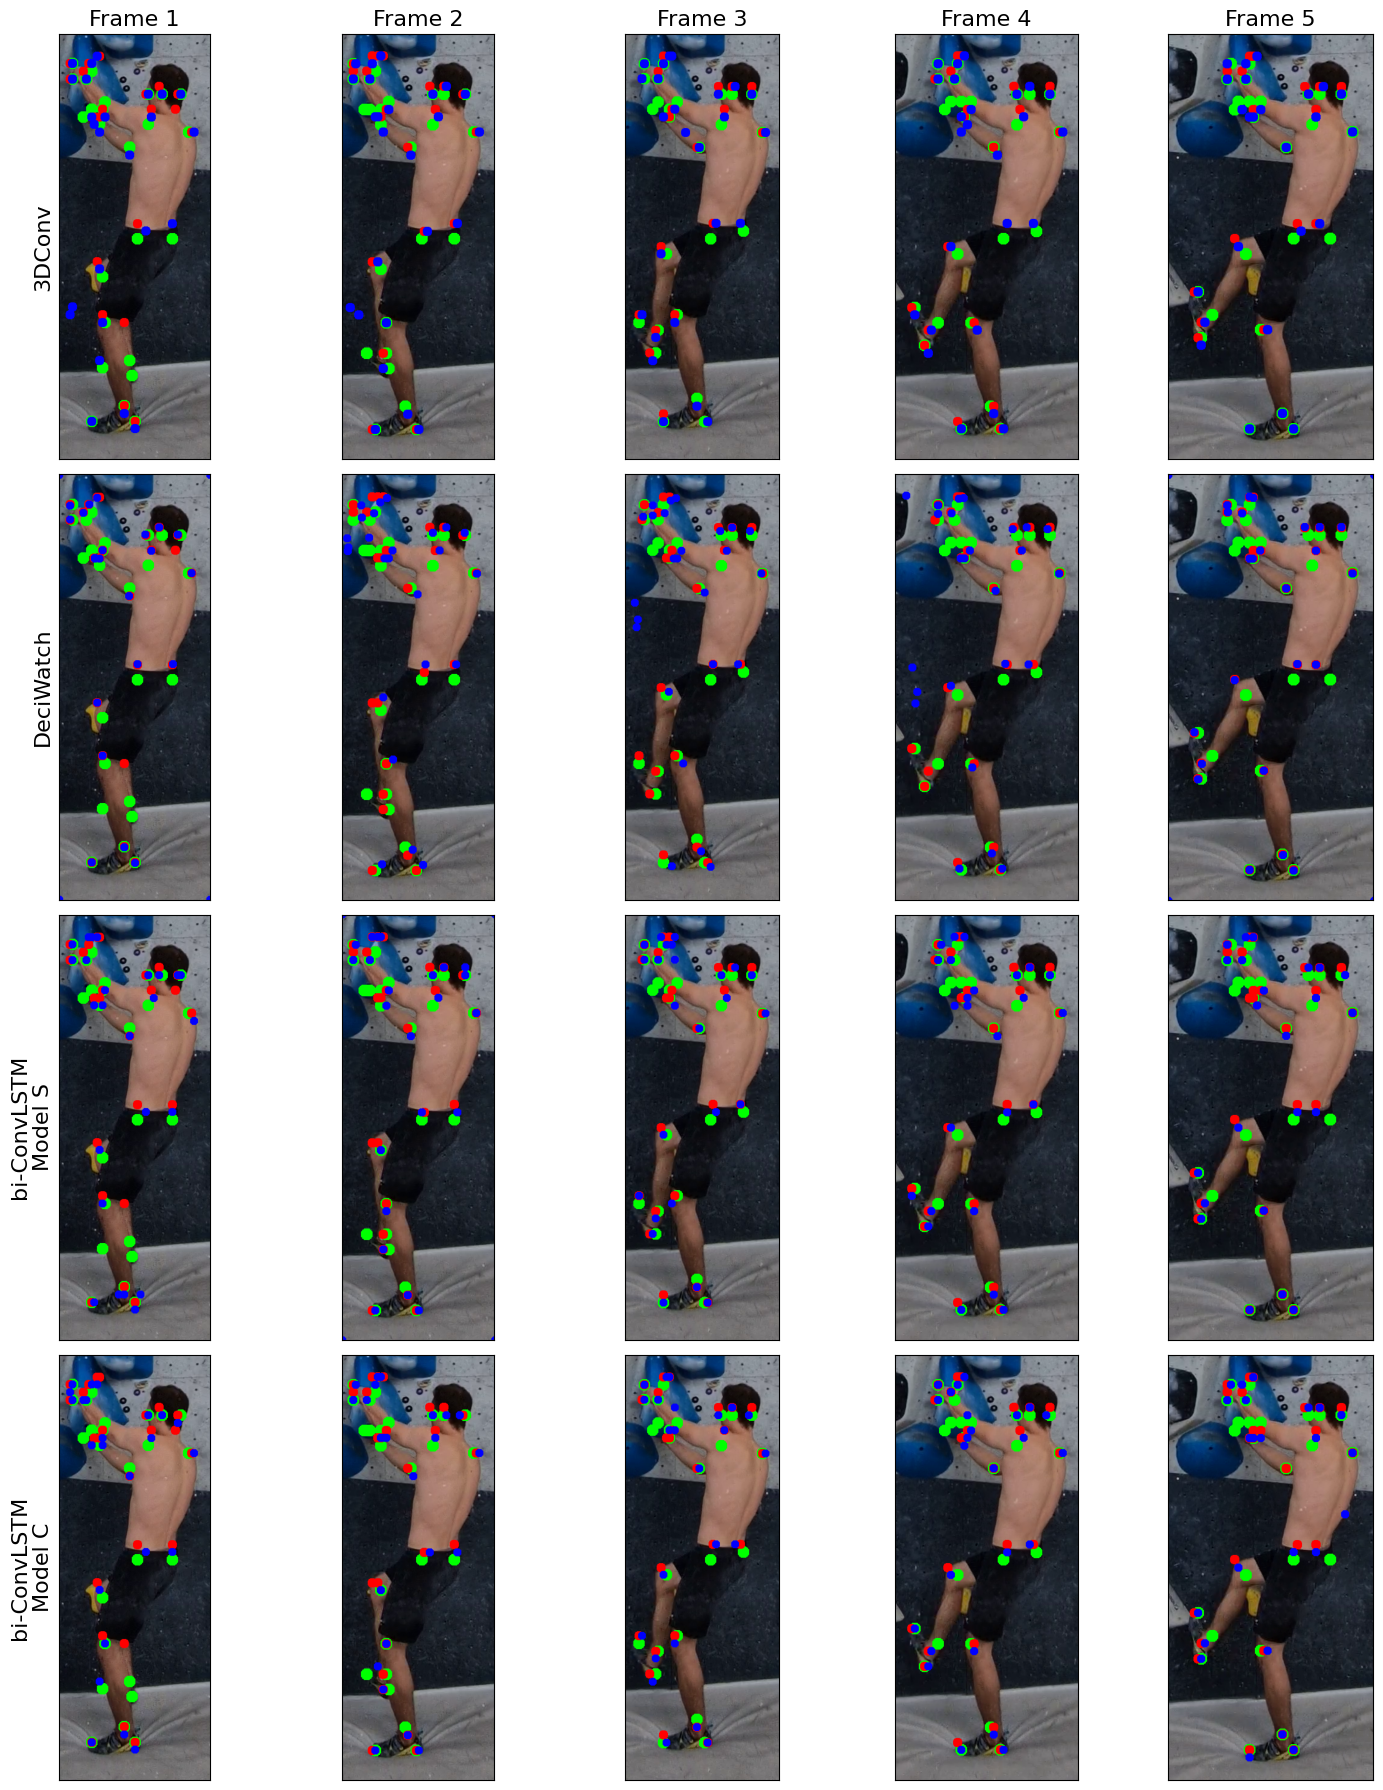

In [133]:
# Path for video
video_idx = 0
video_name = "20220801_155032.mp4"
video_path = data_video_dir_path + video_name

# Loading Mask RCNN predicted video bboxes
video_annotation = np.load(data_annotations_dir_path + video_name.replace(".mp4", ".npz"))
video_bboxes = video_annotation["bboxes"]

# Start and ending frame to visualize
start_frame = 0
end_frame = start_frame + 4
num_frames = end_frame - start_frame + 1

# Radius of drawn disk
radius = 8

# Fontsize
fontsize = 16

# Making plt figure
fig, axs = plt.subplots(4, num_frames, figsize=(15, 18))
for j in range(4):
    for i in range(num_frames):
        axs[j, i].set_yticklabels([])
        axs[j, i].set_xticklabels([])
        axs[j, i].set_xticks([])
        axs[j, i].set_yticks([])
        
axs[0, 0].set_ylabel("3DConv", fontsize=fontsize)
axs[1, 0].set_ylabel("DeciWatch", fontsize=fontsize)
axs[2, 0].set_ylabel("bi-ConvLSTM\nModel S", fontsize=fontsize)
axs[3, 0].set_ylabel("bi-ConvLSTM\nModel C", fontsize=fontsize)

for i in range(num_frames):
    axs[0, i].set_title(f"Frame {i + 1}", fontsize=fontsize)
    
# Extracting predicted keypoints
baseline_keypoints = load_pred_keypoints(data_input_dir_path, video_name, baseline)
deciwatch_keypoints = load_pred_keypoints(data_input_dir_path, video_name, deciwatch, is_deciwatch=True)
unipose_keypoints = load_pred_keypoints(data_input_dir_path, video_name, unipose)
unipose2_keypoints = load_pred_keypoints(data_input_dir_path, video_name, unipose2)

for frame_idx in range(start_frame, end_frame + 1):
    
    # Loading rescaling parameters
    width_scale = (video_bboxes[frame_idx][2] - video_bboxes[frame_idx][0])/56
    height_scale = (video_bboxes[frame_idx][3] - video_bboxes[frame_idx][1])/56
    
    # Loading frame
    frame = get_video_frame(frame_idx, video_path, video_bboxes)
    
    # Ground truth
    gt_keypoints = load_gt_keypoints(data_target_dir_path, video_name, frame_idx)
    frame = draw_keypoints(frame, gt_keypoints, width_scale, height_scale, c="green", radius=radius + 2)
    
    # Mask R-CNN
    mask_rcnn_keypoints = load_mask_rcnn_preds(frame_idx, video_annotation)
    frame = draw_keypoints(frame, mask_rcnn_keypoints, width_scale, height_scale, c="red", radius=radius)
    
    # Baseline
    baseline_frame = draw_keypoints(frame, baseline_keypoints[frame_idx - start_frame], width_scale, height_scale, radius=radius)
    axs[0, frame_idx - start_frame].imshow(baseline_frame)
    
    # DeciWatch
    deciwatch_frame = draw_keypoints(frame, deciwatch_keypoints[frame_idx - start_frame], width_scale, height_scale, radius=radius - 1)
    axs[1, frame_idx - start_frame].imshow(deciwatch_frame)
    
    # Unipose
    unipose_frame = draw_keypoints(frame, unipose_keypoints[frame_idx - start_frame], width_scale, height_scale, radius=radius - 1)
    axs[2, frame_idx - start_frame].imshow(unipose_frame)
    
    # Unipose2
    unipose2_frame = draw_keypoints(frame, unipose2_keypoints[frame_idx - start_frame], width_scale, height_scale, radius=radius - 1)
    axs[3, frame_idx - start_frame].imshow(unipose2_frame)
    
    baseline_keypoint = baseline_keypoints[frame_idx - start_frame]
    deciwatch_keypoint = deciwatch_keypoints[frame_idx - start_frame]
    unipose_keypoint = unipose_keypoints[frame_idx - start_frame]
    unipose2_keypoint = unipose2_keypoints[frame_idx - start_frame]

    gt_keypoint = gt_keypoints.reshape((1, 1, -1))
    baseline_keypoint = baseline_keypoint.reshape((1, 1, -1))
    deciwatch_keypoint = deciwatch_keypoint.reshape((1, 1, -1))
    unipose_keypoint = unipose_keypoint.reshape((1, 1, -1))
    unipose2_keypoint = unipose2_keypoint.reshape((1, 1, -1))
    mask_rcnn_keypoint = mask_rcnn_keypoints.reshape((1, 1, -1))

    input_pck = compute_PCK(gt_keypoint, mask_rcnn_keypoint, norm=0.05)
    baseline_keypoint_pck = compute_PCK(gt_keypoint, baseline_keypoint, norm=0.05)
    deciwatch_keypoint_pck = compute_PCK(gt_keypoint, deciwatch_keypoint, norm=0.05)
    unipose_keypoint_pck = compute_PCK(gt_keypoint, unipose_keypoint, norm=0.05)
    unipose2_keypoint_pck = compute_PCK(gt_keypoint, unipose2_keypoint, norm=0.05)

    print(f"frame {frame_idx} - Mask RCNN", input_pck)
    print(f"frame {frame_idx} - 3DConv", baseline_keypoint_pck)
    print(f"frame {frame_idx} - DeciWatch", deciwatch_keypoint_pck)
    print(f"frame {frame_idx} - Unipose", unipose_keypoint_pck)
    print(f"frame {frame_idx} - Unipose2", unipose2_keypoint_pck)
    print()

plt.tight_layout()
plt.show()

In [134]:
# Path for video
video_path = data_video_dir_path + video_name

# Loading Mask RCNN predicted video bboxes
video_annotation = np.load(data_annotations_dir_path + video_name.replace(".mp4", ".npz"))
video_bboxes = video_annotation["bboxes"]

PCKs = {"input": 0, "baseline": 0, "deciwatch": 0, "unipose": 0, "unipose2": 0}

count = 0

# Start and ending frame to visualize
for start_frame in tqdm(range(video_bboxes.shape[0] - 5)):
    end_frame = start_frame + 4
    num_frames = end_frame - start_frame + 1
        
    # Extracting predicted keypoints
    baseline_keypoints = load_pred_keypoints(data_input_dir_path, video_name, baseline)
    deciwatch_keypoints = load_pred_keypoints(data_input_dir_path, video_name, deciwatch, is_deciwatch=True)
    unipose_keypoints = load_pred_keypoints(data_input_dir_path, video_name, unipose)
    unipose2_keypoints = load_pred_keypoints(data_input_dir_path, video_name, unipose2)

    for frame_idx in range(start_frame, end_frame + 1):
        gt_keypoints = load_gt_keypoints(data_target_dir_path, video_name, frame_idx)
        mask_rcnn_keypoints = load_mask_rcnn_preds(frame_idx, video_annotation)
        
        baseline_keypoint = baseline_keypoints[frame_idx - start_frame]
        deciwatch_keypoint = deciwatch_keypoints[frame_idx - start_frame]
        unipose_keypoint = unipose_keypoints[frame_idx - start_frame]
        unipose2_keypoint = unipose2_keypoints[frame_idx - start_frame]

        gt_keypoint = gt_keypoints.reshape((1, 1, -1))
        baseline_keypoint = baseline_keypoint.reshape((1, 1, -1))
        deciwatch_keypoint = deciwatch_keypoint.reshape((1, 1, -1))
        unipose_keypoint = unipose_keypoint.reshape((1, 1, -1))
        unipose2_keypoint = unipose2_keypoint.reshape((1, 1, -1))
        mask_rcnn_keypoint = mask_rcnn_keypoints.reshape((1, 1, -1))

        input_pck = compute_PCK(gt_keypoint, mask_rcnn_keypoint, norm=0.05)
        baseline_keypoint_pck = compute_PCK(gt_keypoint, baseline_keypoint, norm=0.05)
        deciwatch_keypoint_pck = compute_PCK(gt_keypoint, deciwatch_keypoint, norm=0.05)
        unipose_keypoint_pck = compute_PCK(gt_keypoint, unipose_keypoint, norm=0.05)
        unipose2_keypoint_pck = compute_PCK(gt_keypoint, unipose2_keypoint, norm=0.05)
        
        count += 1

        PCKs["input"] += input_pck
        PCKs["baseline"] += baseline_keypoint_pck
        PCKs["deciwatch"] += deciwatch_keypoint_pck
        PCKs["unipose"] += unipose_keypoint_pck
        PCKs["unipose2"] += unipose2_keypoint_pck
        
PCKs = {k: v/count for k, v in PCKs.items()}
print(PCKs)

 99%|█████████▉| 747/753 [20:50<00:10,  1.67s/it]


ValueError: need at least one array to concatenate

In [135]:
PCKs = {k: v/count for k, v in PCKs.items()}

In [136]:
PCKs

{'input': 0.21353303022198689,
 'baseline': 0.003872693233484857,
 'deciwatch': 0.0038085049478469857,
 'unipose': 0.0035731479005081286,
 'unipose2': 0.0036266381385396933}